# **30 Day Forecast: Amberpet Mandal Weather Conditions**

# **Notebook 3: Feature Engineering & Multivariate Time Series Forecasting**

## Installing & Importing Required Libraries

In [1]:
# Libraries required for data analysis, manipulation, visualization and preprocessing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline
import math  # For mathematical operations

from datetime import datetime, timedelta # For date and time manipulation
from pandas.tseries.offsets import DateOffset # For date offsets
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler  # For feature scaling

import statsmodels.api as sm # For statistical modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # For ACF and PACF plots
from statsmodels.tsa.statespace.varmax import VARMAX # For VARMAX modeling
from statsmodels.tsa.api import VAR # For VAR modeling
from statsmodels.tsa.stattools import grangercausalitytests, adfuller # For Granger causality and ADF test

from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from statsmodels.tools.eval_measures import rmse # For RMSE calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error # For model evaluation

import warnings
warnings.filterwarnings('ignore')

## **Loading Data**

In [2]:
# load 'Amberpet_weather_cleaned.csv'
Amberpet_weather_cleaned = pd.read_csv('Amberpet_weather_cleaned.csv', parse_dates=['Date'], index_col='Date')
Amberpet_weather_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-02-01 to 2025-01-31
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rain (mm)              731 non-null    float64
 1   Min Temp (°C)          731 non-null    float64
 2   Max Temp (°C)          731 non-null    float64
 3   Min Humidity (%)       731 non-null    float64
 4   Max Humidity (%)       731 non-null    float64
 5   Min Wind Speed (Kmph)  731 non-null    float64
 6   Max Wind Speed (Kmph)  731 non-null    float64
dtypes: float64(7)
memory usage: 45.7 KB


## **1.7 Feature Engineering**

### **1.7.1 Log Transformation of highly skewed variables**

In [25]:
# create a function that applies log transformation with masking for zero values
def log_transform_with_mask(df, skewed_cols):
    transformed_dict = {}

    for col in skewed_cols:
        if col in df.columns:
            series = df[col]
            mask = (series != 0).astype(int)
            log_value = np.where(mask, np.log(series), 0)
            transformed_dict[col] = pd.DataFrame({
                'log_value': log_value,
                'mask': mask
            })

    return transformed_dict

skewed_cols = ['Rain (mm)', 'Max Wind Speed (Kmph)', 'Min Wind Speed (Kmph)']
Amberpet_transformed = log_transform_with_mask(Amberpet_weather_cleaned, skewed_cols)

### **1.7.2 Robust scaling of variables with many outliers**

In [26]:
# create a function that applies robust scaling with masking
from sklearn.preprocessing import RobustScaler

def robust_scale_with_mask(df, transformed_dict, additional_cols):
    scaled_dict = {}
    scaler_dict = {}

    # Scale log-transformed columns using their masks
    for col, transformed_df in transformed_dict.items():
        log_vals = transformed_df['log_value'].values.reshape(-1, 1)
        mask = transformed_df['mask'].values.reshape(-1, 1)

        scaler = RobustScaler()
        scaled_vals = np.where(mask, scaler.fit_transform(log_vals), 0)

        scaled_dict[col] = pd.DataFrame({
            'scaled_log': scaled_vals.flatten(),
            'mask': mask.flatten()
        })
        scaler_dict[col] = scaler  # Store scaler for inversion

    # Scale additional columns directly
    for col in additional_cols:
        if col in df.columns:
            raw_vals = df[col].values.reshape(-1, 1)

            scaler = RobustScaler()
            scaled_vals = scaler.fit_transform(raw_vals)

            scaled_dict[col] = pd.DataFrame({
                'scaled': scaled_vals.flatten()
            })
            scaler_dict[col] = scaler  # Store scaler for inversion

    return scaled_dict, scaler_dict

In [8]:
scaled_dict, scaler_dict = robust_scale_with_mask(
    Amberpet_weather_cleaned, Amberpet_transformed, ['Max Temp (°C)']
)

 ### **1.7.3 Stationarity of Time Series Data for the target variables**

In [9]:
# Function to check stationarity using Augmented Dickey-Fuller test
def check_stationarity(df, significance_level=0.05):
    stationarity_results = {}

    for col in df.columns:
        series = df[col].dropna()
        result = adfuller(series)
        p_value = result[1]
        is_stationary = p_value < significance_level

        stationarity_results[col] = {
            'ADF Statistic': result[0],
            'p-value': p_value,
            'Critical Values': result[4],
            'Stationary': is_stationary  # Explicit True/False flag
        }

    return pd.DataFrame(stationarity_results).T

# Run stationarity check
stationarity_df = check_stationarity(Amberpet_weather_cleaned)

# View results
print(stationarity_df)

                      ADF Statistic   p-value  \
Rain (mm)                 -7.568278       0.0   
Min Temp (°C)             -1.360097  0.601249   
Max Temp (°C)             -4.076696  0.001058   
Min Humidity (%)          -2.734353   0.06828   
Max Humidity (%)           -6.39522       0.0   
Min Wind Speed (Kmph)     -6.970617       0.0   
Max Wind Speed (Kmph)     -2.665582  0.080186   

                                                         Critical Values  \
Rain (mm)              {'1%': -3.4394018678958544, '5%': -2.865534780...   
Min Temp (°C)          {'1%': -3.4395677423210493, '5%': -2.865607873...   
Max Temp (°C)          {'1%': -3.4394018678958544, '5%': -2.865534780...   
Min Humidity (%)       {'1%': -3.4395418285955563, '5%': -2.865596454...   
Max Humidity (%)       {'1%': -3.439376877165393, '5%': -2.8655237684...   
Min Wind Speed (Kmph)  {'1%': -3.439376877165393, '5%': -2.8655237684...   
Max Wind Speed (Kmph)  {'1%': -3.4395289262948894, '5%': -2.865590769...   

In [10]:
# Apply differencing to non-stationary columns
# create a function that differences non-stationary columns
def difference_non_stationary(df, stationarity_df):
    differenced_df = df.copy()

    for col in df.columns:
        if not stationarity_df.loc[col, 'Stationary']:
            differenced_df[col] = df[col].diff()

    return differenced_df
differenced_df = difference_non_stationary(Amberpet_weather_cleaned, stationarity_df)

# check stationarity again after differencing
stationarity_after_diff = check_stationarity(differenced_df.dropna())
# View results
print(stationarity_after_diff)

                      ADF Statistic   p-value  \
Rain (mm)                  -7.56449       0.0   
Min Temp (°C)             -9.848665       0.0   
Max Temp (°C)             -4.086242  0.001021   
Min Humidity (%)         -10.956379       0.0   
Max Humidity (%)          -6.424679       0.0   
Min Wind Speed (Kmph)     -6.966921       0.0   
Max Wind Speed (Kmph)      -7.56253       0.0   

                                                         Critical Values  \
Rain (mm)              {'1%': -3.4394144152232995, '5%': -2.865540310...   
Min Temp (°C)          {'1%': -3.4395677423210493, '5%': -2.865607873...   
Max Temp (°C)          {'1%': -3.4394144152232995, '5%': -2.865540310...   
Min Humidity (%)       {'1%': -3.4395418285955563, '5%': -2.865596454...   
Max Humidity (%)       {'1%': -3.4393893552577723, '5%': -2.865529267...   
Min Wind Speed (Kmph)  {'1%': -3.4393893552577723, '5%': -2.865529267...   
Max Wind Speed (Kmph)  {'1%': -3.439606888036868, '5%': -2.8656251219...   

In [12]:
# check info of differenced_df
print(differenced_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-02-01 to 2025-01-31
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rain (mm)              731 non-null    float64
 1   Min Temp (°C)          730 non-null    float64
 2   Max Temp (°C)          731 non-null    float64
 3   Min Humidity (%)       730 non-null    float64
 4   Max Humidity (%)       731 non-null    float64
 5   Min Wind Speed (Kmph)  731 non-null    float64
 6   Max Wind Speed (Kmph)  730 non-null    float64
dtypes: float64(7)
memory usage: 45.7 KB
None


In [13]:
# drop initial NaN values from differencing
differenced_df = differenced_df.dropna()
print(differenced_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-02-02 to 2025-01-31
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rain (mm)              730 non-null    float64
 1   Min Temp (°C)          730 non-null    float64
 2   Max Temp (°C)          730 non-null    float64
 3   Min Humidity (%)       730 non-null    float64
 4   Max Humidity (%)       730 non-null    float64
 5   Min Wind Speed (Kmph)  730 non-null    float64
 6   Max Wind Speed (Kmph)  730 non-null    float64
dtypes: float64(7)
memory usage: 45.6 KB
None


### **1.7.4 Check for relationship between the various time series or variables using Grangers Causality Test**

The grangers_causality_matrix function performs pairwise Granger causality tests for all combinations of the variables.

The test checks if the past values of one variable (e.g., 'Rain (mm)') can predict another variable (e.g., 'Min Temp (°C)').

The test is run for a maximum lag of 12 (maxlag=12), meaning it considers up to 12 previous time steps for prediction.

In [ ]:
#  # create a function for conducting a grangercausalitytests
# from statsmodels.tsa.stattools import grangercausalitytests

# def run_granger_causality_tests(df, max_lag=15, verbose=False):
#     """
#     Run Granger causality tests for all variable pairs in a DataFrame.

#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Stationary, scaled time series data
#     max_lag : int
#         Maximum number of lags to test
#     verbose : bool
#         Whether to print full test output

#     Returns:
#     --------
#     causality_matrix : pd.DataFrame
#         Matrix of minimum p-values for Granger causality between variable pairs
#     """
#     variables = df.columns
#     causality_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))),
#                                     columns=variables, index=variables)

#     for col_y in variables:
#         for col_x in variables:
#             if col_y != col_x:
#                 test_result = grangercausalitytests(df[[col_y, col_x]], maxlag=max_lag, verbose=verbose)
#                 p_values = [round(test_result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(max_lag)]
#                 min_p_value = np.min(p_values)
#                 causality_matrix.loc[col_y, col_x] = min_p_value

#     return causality_matrix

In [ ]:
# # run the granger causality test
# causality_matrix = run_granger_causality_tests(df_stationary, max_lag=10)
# print("Granger Causality Matrix (min p-values):")
# print(causality_matrix)

In [ ]:
# # print the results less than 0.05
# significant_causality = causality_matrix[causality_matrix < 0.05].stack().reset_index()
# significant_causality.columns = ['Cause', 'Effect', 'p-value']
# print("\nSignificant Granger Causality (p < 0.05):")
# print(significant_causality)

In [ ]:
# # visualize
# plt.figure(figsize=(10, 8))
# sns.heatmap(causality_matrix, annot=True, cmap='coolwarm', fmt=".4f")
# plt.title("Granger Causality - Minimum p-values")
# plt.tight_layout()
# plt.show()

Create a causality-informed feature mask

A causality-informed feature mask helps to selectively include variables in the VAR model based on statistically significant Granger causality relationships.

This improves interpretability and reduces noise from weak or non-causal predictors.

In [ ]:
# Create a binary mask (1 = include, 0 = exclude) for each variable pair based on a p-value threshold, typically 𝛼 = 0.05

# create a function
# def build_granger_causality_mask(causality_matrix, alpha=0.05):
#     """
#     Create a binary mask from Granger causality p-values.

#     Parameters:
#     -----------
#     causality_matrix : pd.DataFrame
#         Matrix of Granger causality p-values (row: caused, col: causing)
#     alpha : float
#         Significance threshold for causality

#     Returns:
#     --------
#     mask : pd.DataFrame
#         Binary mask (1 = include, 0 = exclude)
#     """
#     mask = (causality_matrix < alpha).astype(int)
#     np.fill_diagonal(mask.values, 0)  # exclude self-causality
#     return mask


In [ ]:
# mask = build_granger_causality_mask(causality_matrix, alpha=0.05)
# print("Causality-Informed Feature Mask:")
# print(mask)

## **1.8 Model Fitting**

#### **1.8.1 VAR Model**

### Splitting train & test data

In [14]:
# Ensure the last 30 days are reserved for testing
df_train = differenced_df.iloc[:-30]
df_test = differenced_df.iloc[-30:]

print(f"Train set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Train set shape: (700, 7)
Test set shape: (30, 7)


### Model Fitting

In [15]:
# Fit model on training data
model = VAR(df_train)

# Select optimal lag using AIC
lag_results = model.select_order(maxlags=30)
optimal_lag = lag_results.aic
print("Lag Order Selection:")
print(lag_results.summary())
print(f"Optimal lag (AIC): {optimal_lag}")

Lag Order Selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.74       20.79   1.015e+09       20.76
1        16.85      17.22*   2.074e+07       16.99
2        16.62       17.33   1.657e+07       16.90
3        16.40       17.44   1.331e+07      16.80*
4       16.36*       17.72  1.271e+07*       16.89
5        16.41       18.10   1.334e+07       17.06
6        16.39       18.42   1.320e+07       17.18
7        16.45       18.80   1.393e+07       17.36
8        16.50       19.19   1.476e+07       17.54
9        16.54       19.55   1.532e+07       17.71
10       16.59       19.93   1.610e+07       17.88
11       16.65       20.33   1.723e+07       18.08
12       16.71       20.71   1.828e+07       18.26
13       16.77       21.11   1.949e+07       18.45
14       16.79       21.45   1.989e+07       18.60
15       16.85       21.84   2.118e+07       18.78
16       1

In [16]:
# Fit model
var_results = model.fit(optimal_lag)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Oct, 2025
Time:                     22:46:33
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    17.5272
Nobs:                     696.000    HQIC:                   16.7141
Log likelihood:          -12348.2    FPE:                1.08731e+07
AIC:                      16.2015    Det(Omega_mle):     8.17055e+06
--------------------------------------------------------------------
Results for equation Rain (mm)
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                          -10.019461         6.491976           -1.543           0.123
L1.Rain (mm)                     0.146684         0.043087            3.404           0.001
L1.Min Temp 

### **Forecast/Predicting**

In [17]:
# Forecast 30 steps ahead (i.e 30 days)
forecast_steps = 30

# Use the last 'optimal_lag' observations from training data
forecast_input = df_train.values[-optimal_lag:]

# Generate forecast
forecast = var_results.forecast(y=forecast_input, steps=forecast_steps)

In [18]:
# Step 1: Invert differencing
def invert_differencing(original_df, forecast):
    inverted_df = pd.DataFrame(forecast, index=df_test.index, columns=original_df.columns)

    for i, col in enumerate(original_df.columns):
        # Get the last known value before forecast starts
        last_value = original_df[col].iloc[-1]
        inverted_df[col] = inverted_df[col].cumsum() + last_value

    return inverted_df

# Apply differencing inversion
forecast_inverted_diff = invert_differencing(df_train, forecast)

In [19]:
# Step 2: Invert robust scaling
def invert_robust_scaling(scaled_dict, scaler_dict):
    inverted_dict = {}
    for col, scaled_df in scaled_dict.items():
        scaler = scaler_dict[col]

        if 'scaled_log' in scaled_df.columns:
            scaled_vals = scaled_df['scaled_log'].values.reshape(-1, 1)
            mask = scaled_df['mask'].values.reshape(-1, 1)

            inverse_vals = scaler.inverse_transform(scaled_vals)
            log_vals = np.where(mask, inverse_vals, 0)

            inverted_dict[col] = pd.DataFrame({ 'log_value': log_vals.flatten(), 'mask': mask.flatten() })

        elif 'scaled' in scaled_df.columns:
            scaled_vals = scaled_df['scaled'].values.reshape(-1, 1)
            original_vals = scaler.inverse_transform(scaled_vals)
            inverted_dict[col] = pd.DataFrame({ 'original': original_vals.flatten() })

    return inverted_dict

# We need to scale the differenced forecast before inverting the scaling
# Create a dictionary of scaled forecast values using the original scalers
forecast_scaled_dict = {}
for col, scaler in scaler_dict.items():
    if col in forecast_inverted_diff.columns:
        # Check if the original transformation for this column was log scaling
        if col in Amberpet_transformed:
            # Need to apply log transformation first to the differenced forecast
            # before scaling it with the robust scaler
            log_vals = np.where(forecast_inverted_diff[col] != 0, np.log(forecast_inverted_diff[col]), 0).reshape(-1, 1)
            mask = (forecast_inverted_diff[col] != 0).astype(int).values.reshape(-1, 1)
            scaled_vals = np.where(mask, scaler.transform(log_vals), 0)
            forecast_scaled_dict[col] = pd.DataFrame({
                'scaled_log': scaled_vals.flatten(),
                'mask': mask.flatten()
            })
        else:
            # Apply robust scaling directly
            scaled_vals = scaler.transform(forecast_inverted_diff[col].values.reshape(-1, 1))
            forecast_scaled_dict[col] = pd.DataFrame({
                'scaled': scaled_vals.flatten()
            })

# Apply scaling inversion
forecast_inverted_scaled = invert_robust_scaling(forecast_scaled_dict, scaler_dict)

In [20]:
# Step 3: Invert log transform
def invert_log_transform_with_mask(transformed_dict):
    inverted_dict = {}

    for col, df in transformed_dict.items():
        if 'log_value' in df.columns:  # Check if 'log_value' column exists
            log_vals = df['log_value'].values
            mask = df['mask'].values

            # Apply exp only where mask == 1
            original_vals = np.where(mask, np.exp(log_vals), 0)

            inverted_dict[col] = pd.DataFrame({
                'original': original_vals,
                'mask': mask
            })
        elif 'scaled_log' in df.columns: # Handle the output from invert_robust_scaling
            log_vals = df['scaled_log'].values # This is actually the log value after inverse scaling
            mask = df['mask'].values

            # Apply exp only where mask == 1
            original_vals = np.where(mask, np.exp(log_vals), 0)

            inverted_dict[col] = pd.DataFrame({
                'original': original_vals,
                'mask': mask
            })
        elif 'original' in df.columns: # Handle columns that were only scaled
             inverted_dict[col] = df # Pass through columns that weren't log transformed
        else: # Handle columns that were only differenced
            inverted_dict[col] = pd.DataFrame({ 'original': df.values.flatten() })


    return inverted_dict

# Apply log inversion
forecast_inverted_log = invert_log_transform_with_mask(forecast_inverted_scaled)

In [21]:
#  Final function to merge inverted log values into a DataFrame
def merge_inverted_log_to_df(reference_df, inverted_log_dict):
    restored_df = pd.DataFrame(index=reference_df.index)
    for col in reference_df.columns: # Iterate through all columns in the original test set
        if col in inverted_log_dict:
            restored_df[col] = inverted_log_dict[col]['original'].values
        else: # If a column was only differenced, it won't be in inverted_log_dict, so use forecast_inverted_diff
             restored_df[col] = forecast_inverted_diff[col].values
    return restored_df

# Merge restored values into final forecast
final_forecast_restored = merge_inverted_log_to_df(df_test, forecast_inverted_log)
print(final_forecast_restored)

            Rain (mm)  Min Temp (°C)  Max Temp (°C)  Min Humidity (%)  \
Date                                                                    
2025-01-02   3.383285       0.126631      68.214233          5.422127   
2025-01-03   6.678631      -0.093644     102.004293          9.378827   
2025-01-04   8.991822      -0.249831     135.521203          9.134341   
2025-01-05  11.213215      -0.156126     169.126571          7.456586   
2025-01-06  13.849118      -0.107521     203.021247          6.082729   
2025-01-07  16.624449      -0.102639     237.049425          5.419018   
2025-01-08  19.288991      -0.110293     270.981921          5.883343   
2025-01-09  22.002329      -0.137989     304.800415          6.351060   
2025-01-10  24.801623      -0.153244     338.576541          6.463384   
2025-01-11  27.652964      -0.153870     372.383999          6.212991   
2025-01-12  30.474417      -0.147735     406.240610          5.886541   
2025-01-13  33.249704      -0.142963     440.118570

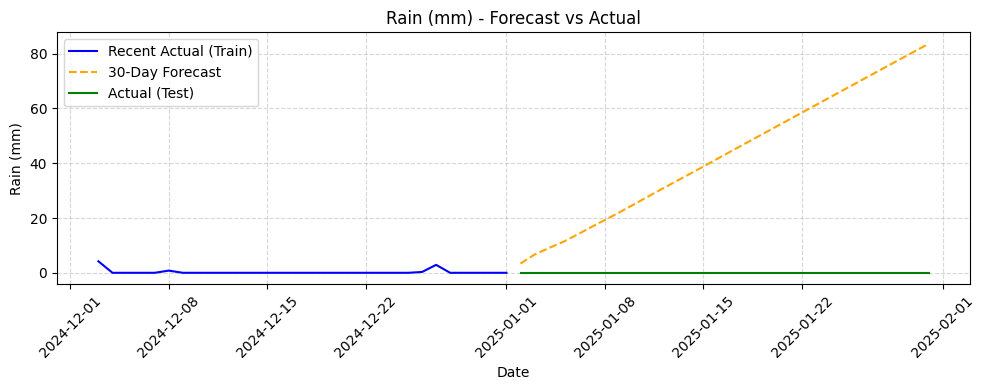

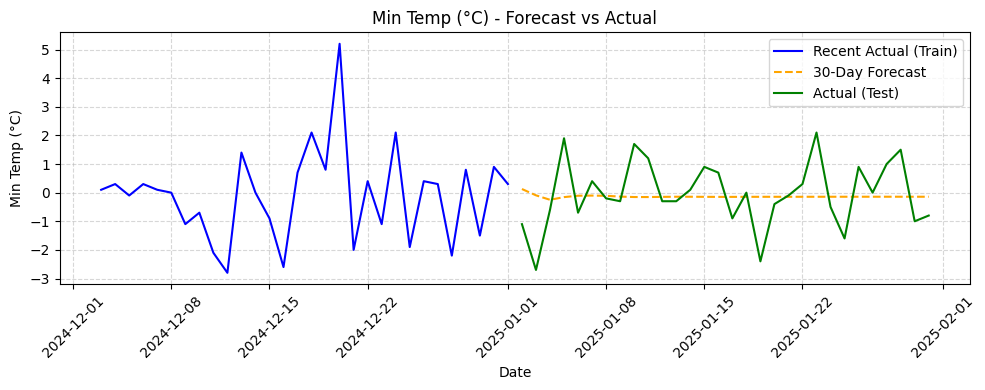

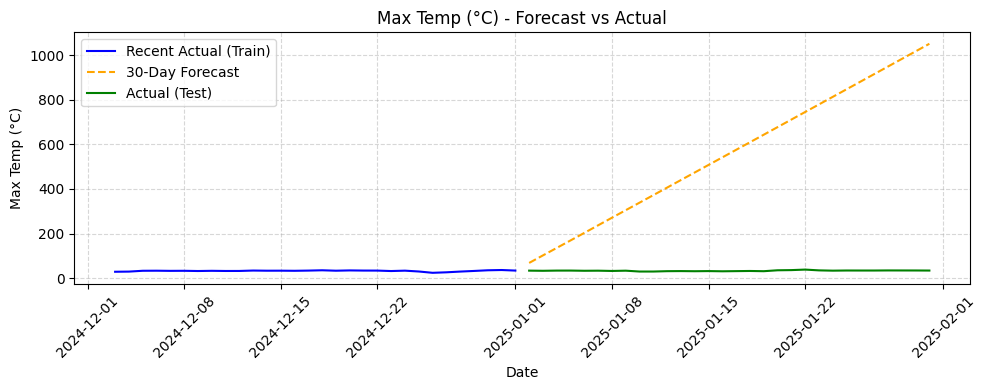

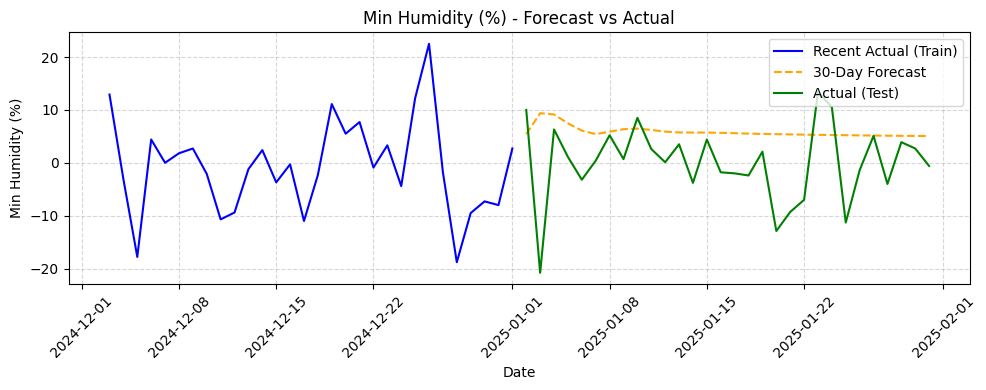

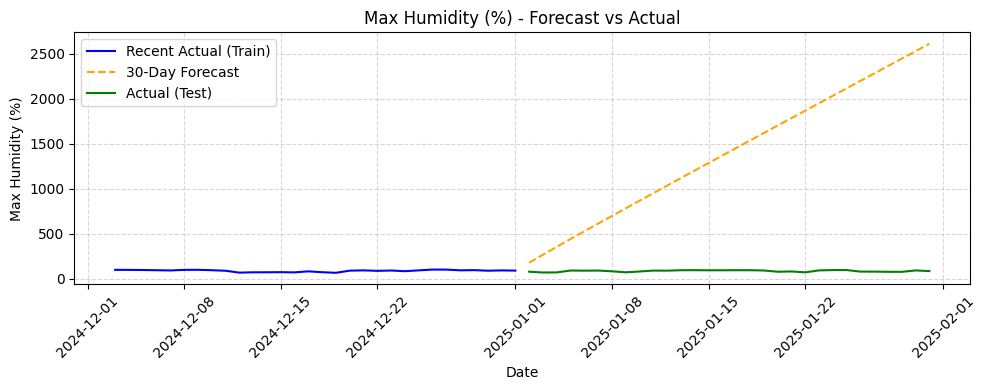

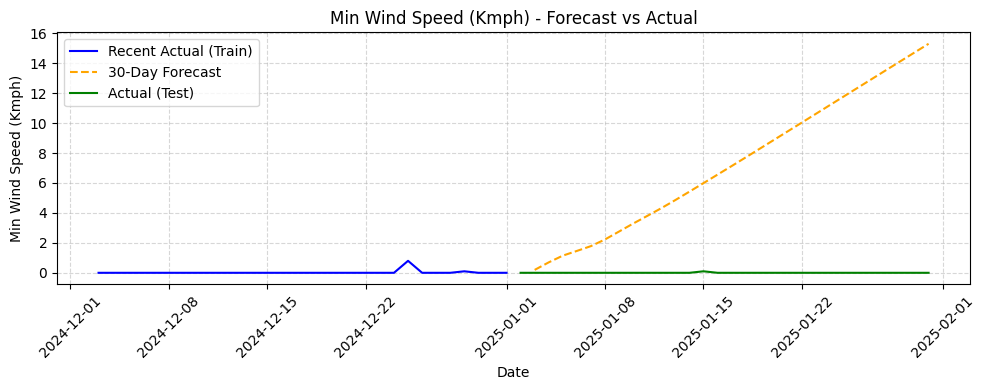

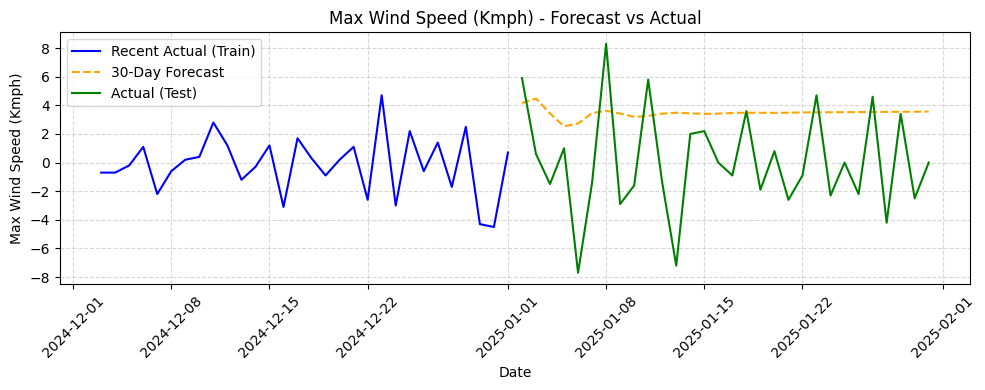

In [22]:
import matplotlib.pyplot as plt

# Number of historical days to show before forecast
history_window = 30
history_df = df_train.iloc[-history_window:]

# Plot forecast vs recent history and test
for col in final_forecast_restored.columns:
    plt.figure(figsize=(10, 4))

    # Plot recent actuals from training
    plt.plot(history_df.index, history_df[col], label='Recent Actual (Train)', color='blue')

    # Plot forecast
    plt.plot(final_forecast_restored.index, final_forecast_restored[col], label='30-Day Forecast', linestyle='--', color='orange')

    # Plot test data (if overlapping)
    overlapping_test = df_test[df_test.index.isin(final_forecast_restored.index)]
    if not overlapping_test.empty:
        plt.plot(overlapping_test.index, overlapping_test[col], label='Actual (Test)', color='green')

    plt.title(f"{col} - Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Model evaluation

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_original = {}
mae_original = {}
mse_original = {}

# Evaluate only on overlapping dates between forecast and test
overlapping_index = df_test.index.intersection(final_forecast_restored.index)

for col in df_test.columns:
    y_true = df_test.loc[overlapping_index, col]
    y_pred = final_forecast_restored.loc[overlapping_index, col]

    # Combine true and predicted values for the current column and drop rows with any NaN
    combined_series = pd.concat([y_true, y_pred], axis=1).dropna()

    if not combined_series.empty:
        y_true_cleaned = combined_series.iloc[:, 0]
        y_pred_cleaned = combined_series.iloc[:, 1]

        mse = mean_squared_error(y_true_cleaned, y_pred_cleaned)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_cleaned, y_pred_cleaned)

        mse_original[col] = mse
        rmse_original[col] = rmse
        mae_original[col] = mae
    else:
        # Handle cases where all values are NaN after dropping
        mse_original[col] = np.nan
        rmse_original[col] = np.nan
        mae_original[col] = np.nan


# Print results
print("Forecast Evaluation Metrics (Original Scale):")
for var in df_test.columns:
    print(f"{var}: MSE = {mse_original[var]:.4f}, RMSE = {rmse_original[var]:.4f}, MAE = {mae_original[var]:.2f}")

Forecast Evaluation Metrics (Original Scale):
Rain (mm): MSE = 2442.6890, RMSE = 49.4236, MAE = 43.19
Min Temp (°C): MSE = 1.3324, RMSE = 1.1543, MAE = 0.89
Max Temp (°C): MSE = 362283.1258, RMSE = 601.8996, MAE = 525.93
Min Humidity (%): MSE = 89.7792, RMSE = 9.4752, MAE = 7.19
Max Humidity (%): MSE = 2266311.0979, RMSE = 1505.4272, MAE = 1320.61
Min Wind Speed (Kmph): MSE = 75.0202, RMSE = 8.6614, MAE = 7.33
Max Wind Speed (Kmph): MSE = 24.1158, RMSE = 4.9108, MAE = 4.17


### **1.8.2 Next Steps:**
- Determine how best to handle variables with outliers, skewed variables & many zero values
- Create & incorporate a causality-informed feature mask into the VAR model
- Validate model assumptions using residual diagnostics
- Understand how shocks propagate by Impulse Response Analysis
- Extend to VARMAX with exogenous regressors (e.g., seasonal indicators, Fourier terms)
- Do univariate time series forecasting for each variable
- Compare with deep learning models (e.g., XGBoost, LSTM) using same features